In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
import xgboost as xgb
import operator
import matplotlib.pyplot as plt
import seaborn as sns
from bayes_opt import BayesianOptimization
import scipy.interpolate
from time import time

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
FOLDS = 4
N_JOBS = 6
SEED = 2016

#DATA = "Base"
#DATA = "Time"
#DATA = "Medians"
#DATA = "Lags"
DATA = "Super"


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Get data
train = pd.read_csv("clean_data/train_" + DATA + ".csv")
y = pd.read_csv("clean_data/y.csv")

X_train = pd.read_csv("clean_data/X_train_" + DATA + ".csv")
y_train = pd.read_csv("clean_data/y_train.csv")

X_trainVal = pd.read_csv("clean_data/X_trainVal_" + DATA + ".csv")
y_trainVal = pd.read_csv("clean_data/y_trainVal.csv")

test = pd.read_csv("clean_data/test_" + DATA + ".csv")

X_test = pd.read_csv("clean_data/X_test_" + DATA + ".csv")
y_test = pd.read_csv("clean_data/y_test.csv")

X_testVal = pd.read_csv("clean_data/X_testVal_" + DATA + ".csv")
y_testVal = pd.read_csv("clean_data/y_testVal.csv")


In [3]:
def xgb_mse(preds, dtrain) :
    labels = dtrain.get_label()
    return ("mse", mean_squared_error(preds, labels))

def run_xgb(xg_params, X_trainVal, y_trainVal, X_testVal, y_testVal, X_train, y_train) :
    xg_trainVal = xgb.DMatrix(X_trainVal, label = y_trainVal)
    xg_testVal = xgb.DMatrix(X_testVal, label = y_testVal)
    xg_train = xgb.DMatrix(X_train, label = y_train)
    
    watchlist = [(xg_trainVal, "train"), (xg_testVal, "eval")]    
    
    # Train model
    xg = xgb.train(
        params = xg_params,
        dtrain = xg_trainVal,
        evals = watchlist, 
        num_boost_round = 100000,
        feval = xgb_mse, 
        maximize = False,
        early_stopping_rounds = 100,
        verbose_eval = False)
    
    #print("XGBOOST best_iteration " + str(xg.best_iteration))
    #print("XGBOOST best_score " + str(xg.best_score))
    
    xg = xgb.train(
        params = xg_params, 
        dtrain = xg_train, 
        num_boost_round = int(xg.best_ntree_limit / 0.67),
        feval = xgb_mse, 
        maximize = False,
        verbose_eval = False)

    return (xg_testVal, xg)

In [4]:
def run_all(max_depth, gamma, min_child_weight, subsample, colsample_bytree, colsample_bylevel, base_score) :
    # Generate y_test predictions to be able to optimize ensemble weights
    xg_params = {"eta" : 0.3, "max_depth" : int(max_depth), "min_child_weight" : int(min_child_weight), 
                 "subsample" : subsample, "colsample_bytree" : colsample_bytree, "colsample_bylevel" : colsample_bylevel, 
                 "base_score" : base_score}
    #print(xg_params)
    
    xg_test = xgb.DMatrix(X_test)

    xg_val, xg = run_xgb(xg_params, X_trainVal, y_trainVal.TARGET, X_testVal, y_testVal.TARGET, X_train, y_train.TARGET)
    preds_y_test = xg.predict(xg_test) 

    # Compute average error
    avgError = mean_squared_error(y_test.TARGET, preds_y_test)
    #print("avgError : " + str(avgError))    
    
    return((-1) * avgError)

In [5]:
max_depth_min = 5
max_depth_max = 10
gamma_min = 0.001
gamma_max = 0.1
min_child_weight_min = 2
min_child_weight_max = 12
subsample_min = 0.4
subsample_max = 1
colsample_bytree_min = 0.5
colsample_bytree_max = 1
colsample_bylevel_min = 0.5
colsample_bylevel_max = 1
base_score_min = 0
base_score_max = 1

start = time()
xgbBO = BayesianOptimization(run_all, {
                                "max_depth" : (max_depth_min, max_depth_max), 
                                "gamma" : (gamma_min, gamma_max),
                                "min_child_weight" : (min_child_weight_min, min_child_weight_max),
                                "subsample" : (subsample_min, subsample_max),
                                "colsample_bytree" : (colsample_bytree_min, colsample_bytree_max),
                                "colsample_bylevel" : (colsample_bylevel_min, colsample_bylevel_max), 
                                "base_score" : (base_score_min, base_score_max),        
    })

In [6]:
xgbBO.explore({
              "max_depth" : [8, 6, 7, 5, 8, 10, 6, 8, 7, 9],
              "gamma" : [0.005, 0.001, 0.01, 0.005, 0.01, 0.1, 0.005, 0.05, 0.01, 0.05], 
              "min_child_weight" : [2, 4, 12, 6, 10, 6, 9, 7, 5, 4],
              "subsample" : [0.6, 0.4, 1, 0.5, 0.6, 0.4, 0.5, 0.9, 0.6, 0.8],
              "colsample_bytree" : [0.5, 0.7, 0.8, 0.6, 0.9, 0.6, 0.8, 0.6, 1, 0.7], 
              "colsample_bylevel" :  [0.8, 0.5, 0.7, 1, 0.7, 0.9, 1, 0.9, 0.8, 0.5],
              "base_score" : [0, 0.6, 0.9, 1, 0.4, 0.5, 0.6, 0.1, 0.2, 0.1], 
              })

In [7]:
init_points = 10
num_iter = 80
xgbBO.maximize(init_points = init_points, n_iter = num_iter)
print("BayesianOptimization took %.2f seconds" % ((time() - start)))

Initialization
----------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   base_score |   colsample_bylevel |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1 | 00m20s | -119.78445 |       0.0000 |              0.8000 |             0.5000 |    0.0050 |      8.0000 |             2.0000 |      0.6000 | 
    2 | 00m11s | -143.18668 |       0.6000 |              0.5000 |             0.7000 |    0.0010 |      6.0000 |             4.0000 |      0.4000 | 
    3 | 01m40s | -101.18149 |       0.9000 |              0.7000 |             0.8000 |    0.0100 |      7.0000 |            12.0000 |      1.0000 | 
    4 | 01m13s | -112.68968 |       1.0000 |              1.0000 |             0.6000 |    0.0050 |      5.0000 |             6.0000 |      0.5000 | 
    5 | 00m10s | -146.15054 |       0.4000 |              0.7000 |             0.9000 

C:\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'nit': 5, 'funcalls': 51, 'grad': array([-0.00191236]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   57 | 01m19s | -104.08597 |       0.7526 |              0.5553 |             0.9720 |    0.0181 |      6.4598 |             5.8591 |      0.4577 | 
   58 | 01m12s | -111.44609 |       0.6219 |              0.9034 |             0.9011 |    0.0223 |      6.7358 |             5.4886 |      0.7176 | 
   59 | 00m59s | -126.18956 |       0.7174 |              0.9083 |             0.7617 |    0.0133 |      6.1826 |             2.0599 |      0.6768 | 
   60 | 01m17s | -111.50628 |       0.2436 |              0.5558 |             0.9290 |    0.0360 |      8.2566 |             6.3869 |      0.6978 | 
   61 | 03m09s | -110.52173 |       0.7776 |              0.9129 |             0.8590 |    0.0014 |      6.5588 |            11.2547 |      0.8719 | 
   62 | 03m25s | -120.40965 |       0.3575 |              0.8523 |             0.8346 |    0.0931 |      6.1678 |            11.9182 |      0.7162 | 
   63 | 00m24s | -132.16474 |       0.2821 |              0.6303 |             0.5147 |    0.0609 | 

In [43]:
history_df = pd.DataFrame(xgbBO.res["all"]["params"])
history_df2 = pd.DataFrame(xgbBO.res["all"]["values"])
history_df = pd.concat((history_df, history_df2), axis = 1)
history_df.rename(columns = { 0 : "RMSE"}, inplace = True)
history_df.index.names = ["Iteration"]
history_df.sort_values(["RMSE"], ascending = False, inplace = True)

history_df = history_df[history_df.RMSE > -150]
display(history_df.head(10))

history_df.to_csv("./BO_XGB_" + DATA + ".csv")

,base_score,colsample_bylevel,colsample_bytree,gamma,max_depth,min_child_weight,subsample,RMSE
Iteration,,,,,,,,
52,0.795,0.540,0.766,0.061,8.770,7.621,0.999,-96.754
75,0.977,0.861,0.983,0.057,5.964,5.487,0.998,-99.736
17,0.000,1.000,0.500,0.100,7.417,8.705,1.000,-100.821
31,0.661,0.799,0.925,0.046,6.958,11.916,0.976,-101.090
0,1.000,1.000,1.000,0.100,6.970,6.149,1.000,-101.628
16,0.013,0.661,0.606,0.099,7.182,8.677,0.887,-101.795
5,1.000,1.000,0.500,0.100,6.712,12.000,1.000,-102.054
4,0.088,0.812,0.973,0.019,7.224,6.307,0.765,-102.572
3,0.354,0.591,0.527,0.019,6.445,11.899,0.747,-103.620


In [44]:
def graphBO(param1, param2, param1min, param1max, param2min, param2max, ratio) :
    x, y, z = history_df[param1].values, history_df[param2].values, history_df["RMSE"].values

    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(param1min, param1max, 100), np.linspace(param2min, param2max, 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function = "multiquadric", smooth = 0.5)
    zi = rbf(xi, yi)

    plt.figure()
    plt.imshow(zi, 
               cmap = "plasma", 
               aspect = ratio,
               vmin = z.min(), 
               vmax = z.max(), 
               origin = "lower",
               extent = [param1min, param1max, param2min, param2max])
    q = plt.scatter(x, y, c = z, cmap = "plasma")
    plt.colorbar(q)
    plt.xlabel(param1)
    plt.ylabel(param2)
    #plt.savefig("figures/XGB_" + param1 + "_" + param2 + ".png")
    plt.show(block = False)

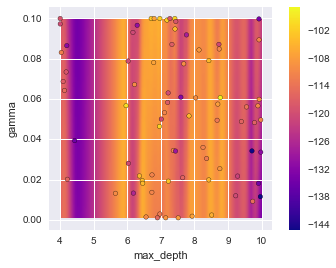

In [45]:
graphBO("max_depth", "gamma", max_depth_min, max_depth_max, gamma_min, gamma_max, 60)

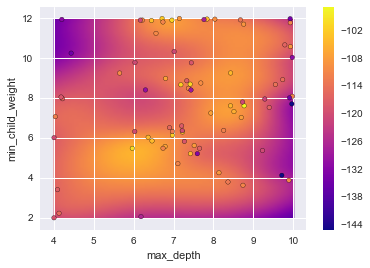

In [46]:
graphBO("max_depth", "min_child_weight", max_depth_min, max_depth_max, min_child_weight_min, min_child_weight_max, 0.5)

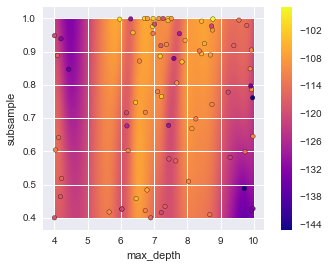

In [47]:
graphBO("max_depth", "subsample", max_depth_min, max_depth_max, subsample_min, subsample_max, 10)

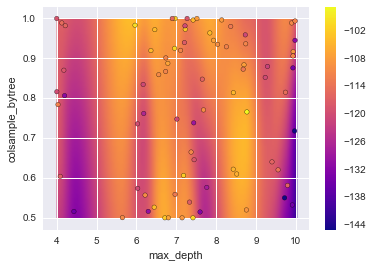

In [48]:
graphBO("max_depth", "colsample_bytree", max_depth_min, max_depth_max, colsample_bytree_min, colsample_bytree_max, 10)

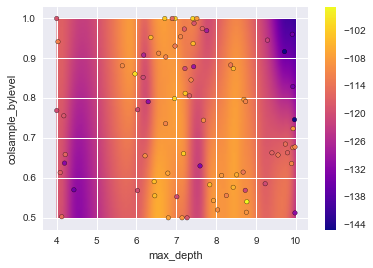

In [49]:
graphBO("max_depth", "colsample_bylevel", max_depth_min, max_depth_max, colsample_bylevel_min, colsample_bylevel_max, 10)

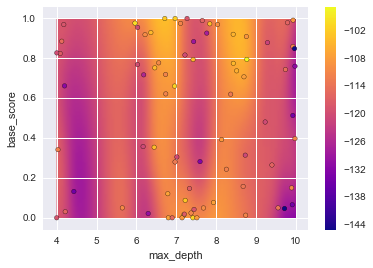

In [50]:
graphBO("max_depth", "base_score", max_depth_min, max_depth_max, base_score_min, base_score_max, 5)

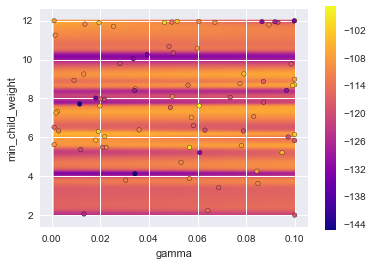

In [66]:
graphBO("gamma", "min_child_weight", gamma_min, gamma_max, min_child_weight_min, min_child_weight_max, 0.008)

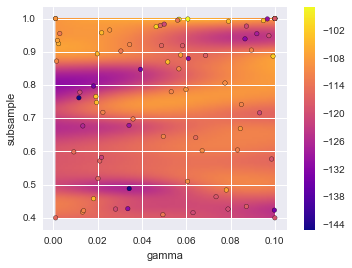

In [67]:
graphBO("gamma", "subsample", gamma_min, gamma_max, subsample_min, subsample_max, 0.15)

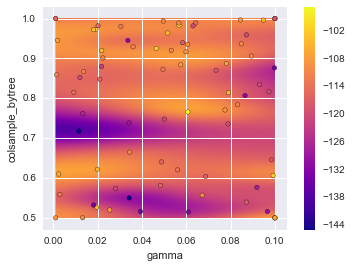

In [68]:
graphBO("gamma", "colsample_bytree", gamma_min, gamma_max, colsample_bytree_min, colsample_bytree_max, 0.18)

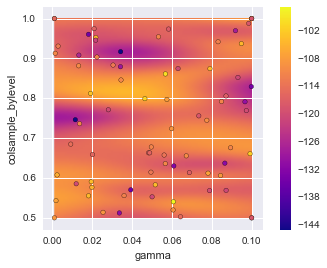

In [54]:
graphBO("gamma", "colsample_bylevel", gamma_min, gamma_max, colsample_bylevel_min, colsample_bylevel_max, 0.2)

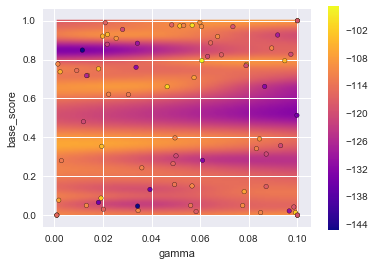

In [55]:
graphBO("gamma", "base_score", gamma_min, gamma_max, base_score_min, base_score_max, 0.08)

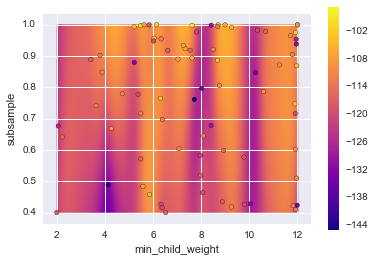

In [56]:
graphBO("min_child_weight", "subsample", min_child_weight_min, min_child_weight_max, subsample_min, subsample_max, 13)

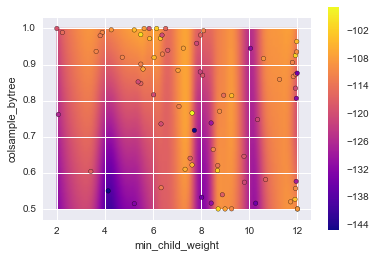

In [57]:
graphBO("min_child_weight", "colsample_bytree", min_child_weight_min, min_child_weight_max, colsample_bytree_min, colsample_bytree_max, 15)

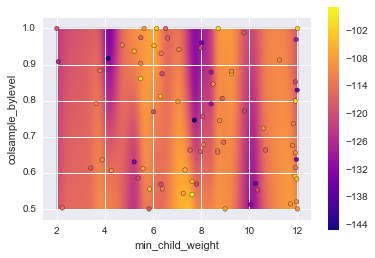

In [58]:
graphBO("min_child_weight", "colsample_bylevel", min_child_weight_min, min_child_weight_max, colsample_bylevel_min, colsample_bylevel_max, 15)

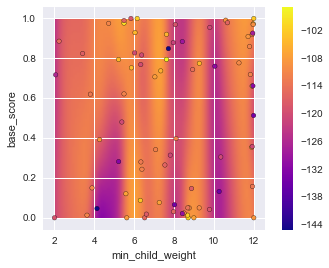

In [59]:
graphBO("min_child_weight", "base_score", min_child_weight_min, min_child_weight_max, base_score_min, base_score_max, 10)

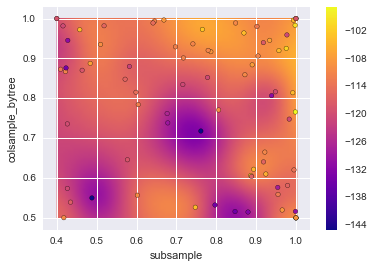

In [60]:
graphBO("subsample", "colsample_bytree", subsample_min, subsample_max, colsample_bytree_min, colsample_bytree_max, 1)

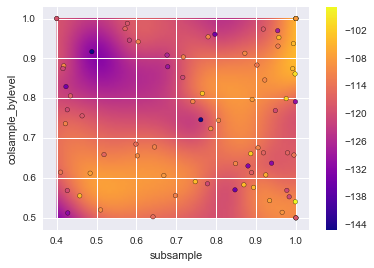

In [61]:
graphBO("subsample", "colsample_bylevel", subsample_min, subsample_max, colsample_bylevel_min, colsample_bylevel_max, 1.0)

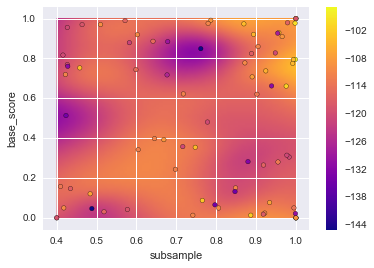

In [62]:
graphBO("subsample", "base_score", subsample_min, subsample_max, base_score_min, base_score_max, 0.5)

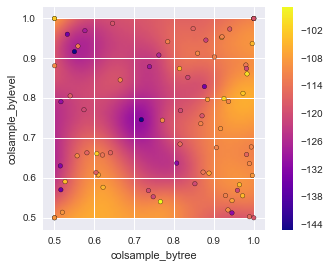

In [63]:
graphBO("colsample_bytree", "colsample_bylevel", colsample_bytree_min, colsample_bytree_max, colsample_bylevel_min, colsample_bylevel_max, 1)

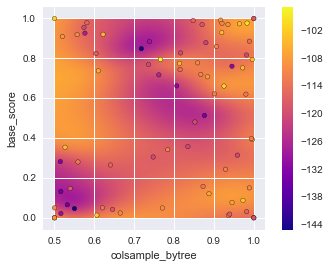

In [64]:
graphBO("colsample_bytree", "base_score", colsample_bytree_min, colsample_bytree_max, base_score_min, base_score_max, 0.5)

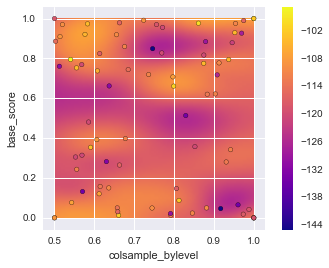

In [65]:
graphBO("colsample_bylevel", "base_score", colsample_bylevel_min, colsample_bylevel_max, base_score_min, base_score_max, 0.5)